# Naive Bayes Classifier

In [ ]:
!pip install -r requirements.txt

In [3]:
import sys
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler,MinMaxScaler


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, confusion_matrix, auc

import matplotlib.pyplot as plt
import nltk
from nltk.corpus import movie_reviews
import random
import textwrap 
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB, GaussianNB
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
import pandas as pd
from collections import Counter, defaultdict
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from wordcloud import WordCloud, ImageColorGenerator

import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [12]:
import nltk
from nltk.corpus import stopwords
import string


class NaiveBayes:

    def __init__(self,df_train, df_val, df_test, n_words = 1000, mute = False, method = "Bernoulli", only_words= False):
        print("-"*60)
        print(f"Initializing Naive Bayes Classifier")
        
        self.only_words = only_words
        self.mute = mute
        self.df_train = df_train
        self.df_val = df_val
        self.df_test = df_test
        self.n_words = n_words


        #Get dependent and independent variables:
        self.Xtrain,self.Xvalidate, self.Xtest, self.ytrain,self.yvalidate, self.ytest = self.get_variables()

        self.non_text_featrues = [col for col in self.Xtrain.columns if col != "messages"]

        # Model Estimation
        pipeline_clf = Pipeline([
            ('transformer',  ColumnTransformer(transformers=[('tfidf', TfidfVectorizer(lowercase=False), "messages"),
                                                            ('pass', "passthrough" , self.non_text_featrues)],verbose=True, n_jobs=-1)),
            ('clf', ComplementNB()), ])


        parameters = {"transformer__tfidf__max_features": (500, 750, 1000, 2000, 3000),
                    'transformer__tfidf__min_df': (0.01,0.05,0.001,0),
                      'transformer__tfidf__max_df': (0.2,0.1, 0.3,0.4, 0.8, 1),
            'clf__alpha': ( 0.022,0.025, 0.028,0.03,0.04, 0.06,0.07, 1),
        }

        ps = self.predefined_split()
        self.model = GridSearchCV(pipeline_clf, parameters,n_jobs=-1, verbose=1,cv=ps, scoring='f1')
        self.model.fit(self.Xtrain ,self.ytrain)
        
        print('Best params after grid search', self.model.best_params_)


        # Prediction & Evaluation

        # Classification of Test Set
        self.classify()
        
        # Evaluation Report Training-Sample
        self.training_classification_report()
        # Evaluation Report Test-Sample
        self.classification_report()

        # ROC-Curve
        self.roc_curve()
        
        # Most influential words in classification
        self.most_important_words()
        
        # Other most influential features in classification
        if self.only_words == False:
            self.most_important_features()


    #Function Definition

    def get_variables(self):
        '''
        Input: 3-split dataset

        Output: 3-Split dependent and independent variabels
        '''
        self.receiver_labels_train = self.df_train["receiver_labels"]
        self.receiver_labels_val = self.df_val["receiver_labels"]
        self.receiver_labels_test = self.df_test["receiver_labels"]
        drop_list = ['class', "game", 'receiver_labels',"absolute_message_index",'relative_message_index']
        drop_list += list(df_test.columns[-17:-3])
        explanatory_col = [col for col in self.df_train.columns if col not in drop_list]
        Xtrain = self.df_train.loc[:, explanatory_col]
        Xvalidate = self.df_val.loc[:, explanatory_col]
        Xtest = self.df_test.loc[:, explanatory_col]
        X_train_val = pd.concat([Xtrain,Xvalidate])


        ytrain = self.df_train["class"].values.ravel()
        yvalidate = self.df_val["class"].values.ravel()
        ytest = self.df_test["class"].values.ravel()
        y_train_val = np.concatenate((ytrain, yvalidate))


        return X_train_val,Xvalidate, Xtest, y_train_val,yvalidate, ytest



    def predefined_split(self):
        '''
        Predefines the split of training and validation set to be later used in the grid search
        '''
        n_train = len(self.df_train)
        n_val = len(self.df_val)
        
        train_list= [-1] * n_train
        val_list = [0] * n_val
        testfold = train_list + val_list
        ps = PredefinedSplit(test_fold = testfold)
        return ps



    def classify(self):
        '''
        Classify a sentence with the NaiveBayes language Model
        '''
        print("-"*60)
        print(f"Classification in progress...")
        self.ytrain_fit = self.model.predict(self.Xtrain)
        self.ytest_fit = self.model.predict(self.Xtest)
        self.yvalidate_fit = self.model.predict(self.Xvalidate)


    def classification_report(self):
        '''
        Print Classification Report
        '''
        print("-"*60)
        print('OoS-Classification Report')
        print(classification_report(self.ytest, self.ytest_fit, target_names=['Truth', 'Lie']))
        tn, fp, fn, tp = confusion_matrix(self.ytest,  self.ytest_fit).ravel()
        print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")


    def training_classification_report(self):
        '''
        Classification Report
        '''
        print("-"*60)
        print('Training-Classification Report')
        print(classification_report(self.ytrain, self.ytrain_fit, target_names=['Truth', 'Lie']))
        tn, fp, fn, tp = confusion_matrix(self.ytrain,  self.ytrain_fit).ravel()
        print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")
        
    def val_classification_report(self):
        '''
        Classification Report
        '''
        print("-"*60)
        print('Validation-Classification Report')
        print(classification_report(self.yvalidate, self.yvalidate_fit, target_names=['Truth', 'Lie']))
        tn, fp, fn, tp = confusion_matrix(self.yvalidate,  self.yvalidate_fit).ravel()
        print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")

    def human_classification_report(self):
        '''
        Classification Report
        '''
        print("-"*60)
        print('Training-Classification Report')
        print(classification_report(self.ytest, self.receiver_labels_test, target_names=['Truth', 'Lie']))
        tn, fp, fn, tp = confusion_matrix(self.ytest, self.receiver_labels_test).ravel()
        print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")
    
    def roc_curve(self):
        '''
        Receiver operating characteristic of Test-Sample
        '''
        fpr, tpr, _ = roc_curve(self.ytest[:], self.ytest_fit[:])
        roc_auc = auc(fpr, tpr)

        # Visualization
        plt.clf
        plt.plot(fpr, tpr, color='tab:orange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='tab:blue', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.legend(loc="lower right")
        plt.title('OoS - Receiver operating characteristic')



    def most_important_words(self, n=15):
        '''
        This function selects the 'n' most important word-features by their
        coefficients for the model and visualizes them in a word cloud.
        '''
        #Iterating over all classes
        feature_tab = PrettyTable()
        feature_tab.add_column("Rank",[i+1 for i in range(n)])

        #Getting the most important features
        feature_dict = {}
        benchmark_tfidf = self.model.best_estimator_['transformer'].named_transformers_['tfidf']
        
        if self.only_words == False:
            num_normal_col = len(self.Xtrain.columns)-1
            features = self.model.best_estimator_["clf"].coef_[0][:-num_normal_col]

        else:
            features = self.model.feature_log_prob_[0][:]
        
        
        
        for feature_number ,coef in enumerate(features):
            feature_dict[feature_number] = coef
        feature_dict = dict(sorted(feature_dict.items(), key=lambda item: item[1], reverse=True))
        

        #Transforming the features back to words
        mif_list = []
        coefficient_list = []
        
        if len(self.model.best_estimator_["clf"].coef_[0][:-num_normal_col]) < n:
            word_to_show = len(self.model.best_estimator_["clf"].coef_[0][:-num_normal_col])
        else:
            word_to_show = n
        for index in range(word_to_show):
            mif_list.append(list(feature_dict.keys())[index])
            coefficient_list.append(round(list(feature_dict.items())[index][1],6))

        
        feature_names = (benchmark_tfidf.get_feature_names())
        

        most_important_features = []
        for feature_index in mif_list:

            most_important_features.append(feature_names[feature_index])


        #Adding class-features to table

        feature_tab.add_column("Words", most_important_features)
        feature_tab.add_column("Coefficient", coefficient_list)

        print("-"*60)
        print('Most Important Words')
        print(feature_tab)


        #Wordcloud
        
        wordcloud_dict = dict()
        for word, coefficient in zip(most_important_features, coefficient_list):
            wordcloud_dict[word] = round((int(coefficient) *10000),0)

        #wordcloud_txt = " ".join(wordcloud_list)

        # Create and generate a word cloud image:
        wordcloud = WordCloud(background_color="white").generate_from_frequencies(wordcloud_dict)

        # Display the generated image:
        fix, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        plt.show()
        

    def most_important_features(self, n=10):
        '''
        This function selects the 'n' most important non-verbal features by their 
        coefficients for the respective classes of the model
        '''
        #Iterating over all classes
        feature_tab = PrettyTable()
        feature_tab.add_column("Rank",[i+1 for i in range(n)])

        #Getting the most important features
        feature_dict = {}

        benchmark_tfidf = self.model.best_estimator_['transformer'].named_transformers_['tfidf']
        num_word_features = benchmark_tfidf.get_params(deep=True)["max_features"]
        num_normal_col = len(self.Xtrain.columns)-1
        features = self.model.best_estimator_["clf"].coef_[0][-num_normal_col:]


        for feature_number ,coef in enumerate(features):
            feature_dict[feature_number] = coef
        feature_dict = dict(sorted(feature_dict.items(), key=lambda item: item[1], reverse=True))


        mif_list = []
        coefficient_list = []
        for index in range(n):
            mif_list.append(list(feature_dict.keys())[index])
            coefficient_list.append(round(list(feature_dict.items())[index][1],6))

        most_important_features = []

        for index in mif_list:
            key = self.non_text_featrues[index]
            most_important_features.append(key)

        feature_tab.add_column("Variable", most_important_features)
        feature_tab.add_column("Coefficient", coefficient_list)

        print("-"*60)
        print('Most Important Other Features')
        print(feature_tab)
       
    
    def compare_to_human(self):
        tn, fp, fn, tp = confusion_matrix(self.receiver_labels_test,  self.ytest_fit).ravel()
        return {"TN": tn, "FP":fp, "FN":fn, "TP":tp}


In [13]:
df_train = pd.read_csv("train_preprocessed.csv")
df_val = pd.read_csv("validation_preprocessed.csv")
df_test = pd.read_csv("test_preprocessed.csv")

In [14]:
def change_class(df):
        df["class"] = df["class"].replace(1, "dummy")
        df["class"] = df["class"].replace(0, 1)
        df["class"] = df["class"].replace("dummy", 0)
        return df

df_train = change_class(df_train)
df_val = change_class(df_val)
df_test = change_class(df_test)

In [15]:
df_train.messages = df_train.messages.astype(str)
df_val.messages = df_val.messages.astype(str)
df_test.messages = df_test.messages.astype(str)

In [16]:
df_train.game_score_delta = abs(df_train.game_score_delta)
df_val.game_score_delta = abs(df_val.game_score_delta)
df_test.game_score_delta = abs(df_test.game_score_delta)

In [17]:
df_train.columns

Index(['messages', 'class', 'receiver_labels', 'absolute_message_index',
       'relative_message_index', 'years', 'game_score', 'game_score_delta',
       'game', 'emojis_binary', 'ADJ', 'ADP', 'ADV', 'AUX', 'INTJ', 'CONJ',
       'NOUN', 'DET', 'PROPN', 'NUM', 'VERB', 'PART', 'PRON', 'SCONJ',
       'No_sents', 'No_chars', 'speakers_austria', 'speakers_england',
       'speakers_france', 'speakers_germany', 'speakers_italy',
       'speakers_russia', 'speakers_turkey', 'receivers_austria',
       'receivers_england', 'receivers_france', 'receivers_germany',
       'receivers_italy', 'receivers_russia', 'receivers_turkey',
       'seasons_Fall', 'seasons_Spring', 'seasons_Winter'],
      dtype='object')

------------------------------------------------------------
Initializing Naive Bayes Classifier
Fitting 1 folds for each of 960 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   31.2s finished


Best params after grid search {'clf__alpha': 0.022, 'transformer__tfidf__max_df': 0.4, 'transformer__tfidf__max_features': 3000, 'transformer__tfidf__min_df': 0}
------------------------------------------------------------
Classification in progress...
------------------------------------------------------------
Training-Classification Report
              precision    recall  f1-score   support

       Truth       0.97      0.74      0.84     13901
         Lie       0.07      0.45      0.13       647

    accuracy                           0.73     14548
   macro avg       0.52      0.59      0.48     14548
weighted avg       0.93      0.73      0.81     14548

TN: 10259
FP: 3642
FN: 358
TP: 289
------------------------------------------------------------
OoS-Classification Report
              precision    recall  f1-score   support

       Truth       0.94      0.76      0.84      2501
         Lie       0.16      0.49      0.24       240

    accuracy                           0.7

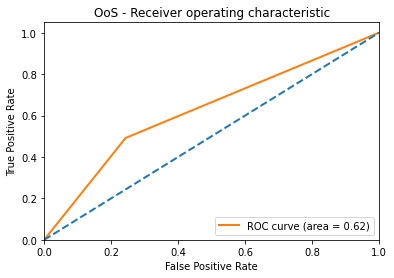

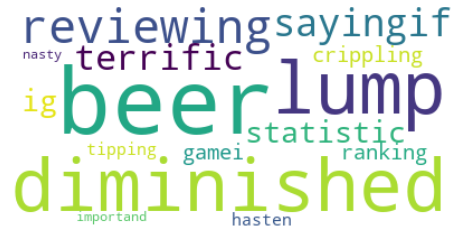

------------------------------------------------------------
Most Important Other Features
+------+----------------+-------------+
| Rank |    Variable    | Coefficient |
+------+----------------+-------------+
|  1   |      CONJ      |   20.96296  |
|  2   | emojis_binary  |   11.10119  |
|  3   |      NUM       |  10.334283  |
|  4   | seasons_Winter |    9.6369   |
|  5   |      INTJ      |   9.25184   |
|  6   |     SCONJ      |   8.950898  |
|  7   | seasons_Spring |   8.447229  |
|  8   |  seasons_Fall  |   8.433648  |
|  9   |      PART      |   8.211265  |
|  10  |      ADJ       |   8.153697  |
+------+----------------+-------------+


In [18]:
CNB = NaiveBayes(df_train,df_val,df_test)

In [19]:
CNB.compare_to_human()

{'TN': 188, 'FP': 78, 'FN': 1827, 'TP': 648}

In [20]:
CNB.val_classification_report()

------------------------------------------------------------
Validation-Classification Report
              precision    recall  f1-score   support

       Truth       0.97      0.78      0.87      1360
         Lie       0.08      0.48      0.14        56

    accuracy                           0.77      1416
   macro avg       0.53      0.63      0.51      1416
weighted avg       0.94      0.77      0.84      1416

TN: 1067
FP: 293
FN: 29
TP: 27


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=efdb1931-d19c-4850-b12b-726a7087f8c0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>